# Predict Masked Face or Not Masked Face

The purpose of this notebook is to detect masked or not masked faces from a provided image by using our trained neural network model. Make sure that the network weights are saved in `data/classifier_model_weights` folder. If you want to retrain the model, please refer `scripts/train_mask_nomask.ipynb` notebook. 

This notebook have an endpoint `predict_masked_faces` method to deploy this model in [dploy.ai](www.dploy.ai) platform. More details about this function is provided below.

## Import Libraries and Global Variables

In [1]:
# Add submodule retinaface-tf2 to detect faces
import os, sys
ROOT_DIR = os.path.dirname(os.path.abspath(os.curdir))
sub_module_dir = os.path.join(ROOT_DIR, 'retinaface-tf2')
if sub_module_dir not in sys.path: # add retinaface-tf2 repo to PATH
    sys.path.append(sub_module_dir)
from modules.models import RetinaFaceModel
from modules.utils import pad_input_image, recover_pad_output, load_yaml

# Python default libraries
from pathlib import Path
import time
import base64

# processing images
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

# visualising the data 
import matplotlib.pyplot as plt

# masked or not classification
import tensorflow as tf

# Disable TF warnings (Disabling the warnings is not a good practice but we disable it to make this notebook prettier)
tf.get_logger().setLevel('ERROR')

# Max enabled image width is set as 850. If greater we will resize the input images 
BASEWIDTH = 850

## Load Face Detection Model

The first stage of the model is detecting the faces from a given image. Therefore, we are using the state of the art tensorflow implementation of `retina face` model.

In [2]:
retina_face_dir = Path(ROOT_DIR) / 'retinaface-tf2'
retinaface_cfg_path = retina_face_dir / 'configs' / 'retinaface_mbv2.yaml'
retinaface_cfg = load_yaml(retinaface_cfg_path)

# define network
model = RetinaFaceModel(retinaface_cfg, training=False, iou_th=0.4, score_th=0.5)

# load checkpoint
checkpoint_dir = retina_face_dir / retinaface_cfg['sub_name']
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/Users/baturayofluoglu/anaconda3/envs/model-zoo/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Helper Functions for Face Detection

In [3]:
def resize_image(img):
    # Resize image by keeping the aspect ratio if image witdth is greater than BASEWIDTH
    if img.size[0] > BASEWIDTH:
        wpercent = (BASEWIDTH / float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((BASEWIDTH,hsize), Image.ANTIALIAS)
    return img

def detect_faces(img_raw):
    img = np.float32(img_raw.copy())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img, pad_params = pad_input_image(img, max_steps=max(retinaface_cfg['steps']))
    detected_faces = model(img[np.newaxis, ...]).numpy()
    return recover_pad_output(detected_faces, pad_params)

def get_detected_face_coordinates(detected_faces, img_width, img_height):
    detected_face_coordinates = []
    for detected_face in detected_faces: 
        x1 = int(detected_face[0] * img_width)
        y1 = int(detected_face[1] * img_height)
        x2 = int(detected_face[2] * img_width)
        y2 = int(detected_face[3] * img_height)
        detected_face_coordinates.append([x1, y1, x2, y2])
    return detected_face_coordinates

## Load Mask Classification Model

After detecting the faces, we crop the faces from the given image and run classifier model to predict whether a person wears a mask or not. 

In [9]:
classifier_dir = Path(ROOT_DIR) / 'data' / 'classifier_model_weights'
classifier = tf.keras.models.load_model(classifier_dir / 'best.h5')

### Helper Function for Mask Classification

In [10]:
def classify_faces(img_raw, face_coords):
    classification_scores = []
    # Iterate over detected face coordinates to find
    for coords in face_coords:
        x1, y1, x2, y2 = coords
        cropped_face = img_raw.crop(coords)
        cropped_face_np = np.float32(cropped_face)
        img = cv2.cvtColor(cropped_face_np, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (112, 112)) 
        preprocessed_img = tf.keras.applications.mobilenet.preprocess_input(img)
        preprocessed_img = preprocessed_img[np.newaxis, ...]
        pred = classifier.predict(preprocessed_img)[0][0]
        classification_scores.append(pred)
    return classification_scores

## Annotate Output Image  

To visualize our model, we annote the provided image. The detected faces are annotated with bounding boxes. The box has `green` color if the detected face has a mask, otherwise it is `red`. The predicted class is written on top of the bounding box as `masked` or `not masked`. The score near the predicted class label represents the `sigmoid function` prediction score of the classification network's last layer. It is between `0` and `1`. If it is close to `1`, it means that the person more likely to has a `mask` on his/her face. Refer to the end of this notebook to see the annotated image example.

In [39]:
def annotate_image(img, face_coords, classified_face_scores, classification_labels):
    pil_draw = ImageDraw.Draw(img)
    for idx, coords in enumerate(face_coords):
        x1, y1, x2, y2 = coords
        label = classification_labels[idx]
        color = 'green' if label == 'masked' else 'red'
        display_str = "{}: {:.2f}".format(label, classified_face_scores[idx])

        # Draw rectangle for detected face
        pil_draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
        
        # Draw label text box
        # portion of image width you want text width to be
        img_fraction = 0.2
        font_size = 5  # starting font size
        
        font = ImageFont.truetype("Arial.ttf", font_size)
        image_size = img.size[0]
        
        while font.getsize(display_str)[0] < img_fraction * image_size:
            # iterate until the text size is just larger than the criteria
            font_size += 1
            font = ImageFont.truetype("Arial.ttf", font_size)

        # Find coordinates of bounding text box
        w, h = font.getsize(display_str)
        pil_draw.rectangle([x1, y1, x1 + w, y1 + h], fill=color)
        pil_draw.text((x1, y1), display_str, font=font)
    return img

def convert_pil_to_base64(annotated_image, image_type):
    buffered = BytesIO()
    if image_type == 'jpg':
        annotated_image.save(buffered, format='jpeg')
    else:
        annotated_image.save(buffered, format=image_type)
    annotated_image_base64 = base64.b64encode(buffered.getvalue())
    return annotated_image_base64.decode('utf-8')

## Endpoint Function To Deploy our Model in Dploy.ai

`Dploy.ai` provides a very easy endpoint annotation. By typing `#' @dploy endpoint predict`, we are telling `dploy.ai` that when our model is deployed, the API will use this function. `body` argument will be the posted dictionary via the API and the return dictionary will be the api response. 
```
{
 image: <Base64 Image String>,
 type: <Image Type e.g. jpg, jpeg, png>
}
```
and the response dictionary will be 
```
{
    'detected_face_coordinates': <the bounding box coordinates of the detected faces e.g. 
                                 [[x1, y1, x2, y2], [x1, y1, x2, y2]]>,
    'detected_mask_scores': <the prediction score of the detected faces between 0 and 1 e.g.
                            [0.8, 0.99, 0.001]>,
    'detected_face_labels': <human readible classification results of the detected faces e.g.
                            [masked, masked, not masked]>,
    'annotated_image': <annotated base64 image that visualizes the prediction results with  
                       bounding boxes and text labels>
}
```

In [40]:
#' @dploy endpoint predict
def predict_masked_faces(body):
    base64_image = body['image'].encode('utf-8')
    image_type = body['type']
    
    # Convert image from base64 to PIL Image and resize it to improve the performance
    img_raw = Image.open(BytesIO(base64.b64decode(base64_image)))
    img_raw = resize_image(img_raw)

    # Detect face coordinates from the raw image
    detected_faces = detect_faces(img_raw)

    # Get detected face coordinates
    img_width, img_height  = img_raw.size
    face_coords = get_detected_face_coordinates(detected_faces, img_width, img_height)
    
    # Classify detected faces whether they have a mask or not
    classified_face_scores = classify_faces(img_raw, face_coords)
    
    # Find labels
    classification_labels = np.where(np.array(classified_face_scores) > 0.5, 'masked', 'not masked').tolist()
    
    # Annotate base image with detected faces and mask classification
    annotated_image = annotate_image(img_raw, face_coords, classified_face_scores, classification_labels)
    
    # Convert PIL image to base64
    annotated_image_base_64 = convert_pil_to_base64(annotated_image, image_type)
    
    return {
            'detected_face_coordinates': face_coords,
            'detected_mask_scores': classified_face_scores,
            'detected_face_labels': classification_labels,
            'annotated_image': annotated_image_base_64
           }

## Test Entire Pipeline with Dploy Endpoint Function

Test function to run entire pipeline. 

Image is processed in 0.4814462661743164 seconds


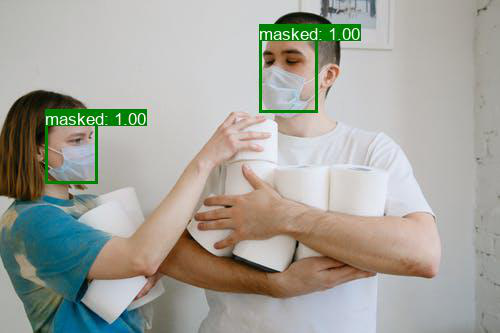

In [41]:
import json
_time = time.time()
with open(os.path.join(ROOT_DIR, "ex_img.jpg"), "rb") as img_file:
    # We need to convert jpeg image into base64 string image to serialize the image.
    body = {
        'image': base64.b64encode(img_file.read()).decode('utf-8'),
        'type': 'jpg'
    }
    response = predict_masked_faces(body)

print('Image is processed in {} seconds'.format(time.time() - _time))

# Show Annotated Image to give an idea what model prediction looks like
img = Image.open(BytesIO(base64.b64decode(response['annotated_image'])))
img